<a href="https://colab.research.google.com/github/kmalangwasila/Revenue-Forecasting-using-Machine-Learning-Algorithms/blob/main/Copy_of_Revenue_Forecasting_Tax_Admin_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Revenue Forecasting in a Tax Administration — End-to-End

**Objective:** Build a reproducible revenue forecasting pipeline using monthly revenue data (5 years), feature engineering, statistical tests, and six machine learning algorithms. This notebook is designed for classroom use — each step contains code and explanatory notes so students can follow along and adapt to real tax data.

**What you will learn:**

- Simulating or loading monthly revenue + macro / compliance drivers
- Exploratory Data Analysis (EDA)
- Data cleaning and transformations
- Feature engineering for time series (lags, rolling stats, seasonality)
- Statistical feature selection (OLS p-values)
- Training and cross-validating multiple ML models (time-series CV)
- Hold-out evaluation and model selection (RMSE, MAPE, R²)
- Recursive multi-step forecasting with the best model
- Practical notes on productionising the model

**Prerequisites:** Python packages: pandas, numpy, matplotlib, scikit-learn, statsmodels, joblib, nbformat.

Run each code cell in order. Replace the simulated dataset with your real monthly series and driver variables when ready.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1) Setup: imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# sklearn & statsmodels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm

print('Libraries imported successfully')

Libraries imported successfully


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

# Reproducibility
rng = np.random.default_rng(123)

# Dates (Jan 2020 - Dec 2024)
dates = pd.date_range(start='2020-01-01', end='2024-12-01', freq='MS')
n = len(dates)
month = dates.month.values
t = np.arange(n)

# Drivers (synthetic but smoother)
gdp_growth = 0.04 + 0.01 * np.sin(2 * np.pi * month / 12) + rng.normal(0, 0.002, n)
cpi_inflation = 0.08 + 0.015 * np.cos(2 * np.pi * (month - 3) / 12) + rng.normal(0, 0.003, n)
fx_mwk_usd = 750 + 4 * t + 20 * np.sin(2 * np.pi * month / 6) + rng.normal(0, 5, n)
fuel_price_index = 100 + 0.3 * t + 3 * np.sin(2 * np.pi * month / 12) + rng.normal(0, 1, n)
audits_launched = rng.poisson(12 + 1.5 * np.sin(2 * np.pi * month / 12), n)
compliance_actions = rng.poisson(28 + 2 * np.cos(2 * np.pi * (month-2) / 12), n)
policy_change = (dates >= '2022-07-01').astype(int)

# Revenue generation (stronger signal, less noise)
base = 150_000
trend = 1000 * t
seasonality = 8000 * np.sin(2 * np.pi * month / 12) + 5000 * np.cos(2 * np.pi * month / 12)
macro_effects = (
    25_000 * gdp_growth
    - 8_000 * cpi_inflation
    + 6 * fx_mwk_usd
    + 120 * fuel_price_index
    + 350 * audits_launched
    + 250 * compliance_actions
    + 15_000 * policy_change
)
noise = rng.normal(0, 5000, n)  # much smaller noise
revenue = np.maximum(base + trend + seasonality + macro_effects + noise, 20_000)

df = pd.DataFrame({
    'date': dates,
    'year': dates.year,
    'month': dates.month,
    'gdp_growth': gdp_growth,
    'cpi_inflation': cpi_inflation,
    'fx_mwk_usd': fx_mwk_usd,
    'fuel_price_index': fuel_price_index,
    'audits_launched': audits_launched,
    'compliance_actions': compliance_actions,
    'policy_change': policy_change,
    'revenue_mwk_millions': revenue
})

# Save to Excel file
output_path = "/mnt/data/tax_revenue_simulated_clean.xlsx"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df.to_excel(output_path, index=False)

## 2) Simulate 5 years of monthly revenue data (or load your data)

Below we create a plausible synthetic dataset with monthly revenue and drivers (GDP growth, CPI, FX, fuel index, audits, compliance actions, and a policy change). **In your class exercise**: either use this simulated data or replace this block with `pd.read_csv('your_revenue.csv')`.

In [ ]:
file_path = '/mnt/data/tax_revenue_simulated_clean.xlsx'
df = pd.read_excel(file_path)
df.head()

,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
0,2020-01-01,2020,1,0.043022,0.085871,765.538941,101.008446,8,39,0,186717.004505
1,2020-02-01,2020,2,0.047925,0.091315,770.041447,102.961833,12,24,0,185468.555784
2,2020-03-01,2020,3,0.052576,0.094051,762.044909,103.813189,11,28,0,193243.884071
3,2020-04-01,2020,4,0.049048,0.091608,745.949785,102.747280,13,26,0,188749.786887
4,2020-05-01,2020,5,0.046840,0.083191,747.253058,100.974620,13,28,0,183261.906810


In [ ]:
# df = pd.read_csv(r"C:\Users\kmalangwasila\OneDrive - Malawi Revenue Authority\Desktop\ML Revene Forecasting\tax_revenue_simulated.csv")

In [ ]:
df.head()

,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
0,2020-01-01,2020,1,0.043022,0.085871,765.538941,101.008446,8,39,0,186717.004505
1,2020-02-01,2020,2,0.047925,0.091315,770.041447,102.961833,12,24,0,185468.555784
2,2020-03-01,2020,3,0.052576,0.094051,762.044909,103.813189,11,28,0,193243.884071
3,2020-04-01,2020,4,0.049048,0.091608,745.949785,102.747280,13,26,0,188749.786887
4,2020-05-01,2020,5,0.046840,0.083191,747.253058,100.974620,13,28,0,183261.906810


In [ ]:
df.tail()

,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
55,2024-08-01,2024,8,0.030173,0.070355,992.862602,114.101009,8,25,1,244795.580126
56,2024-09-01,2024,9,0.028276,0.062470,971.326085,113.941273,15,28,1,248720.640899
57,2024-10-01,2024,10,0.028363,0.065100,967.994105,113.185957,12,29,1,246629.072849
58,2024-11-01,2024,11,0.035433,0.073478,963.729090,116.046432,6,30,1,250956.528408
59,2024-12-01,2024,12,0.041969,0.082362,996.309723,115.424828,10,27,1,251651.924709


## 3) Exploratory Data Analysis (EDA)

Inspect the data structure, summary statistics, and visualize the revenue time-series. Look for trends, seasonality, and obvious anomalies.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  60 non-null     datetime64[ns]
 1   year                  60 non-null     int64         
 2   month                 60 non-null     int64         
 3   gdp_growth            60 non-null     float64       
 4   cpi_inflation         60 non-null     float64       
 5   fx_mwk_usd            60 non-null     float64       
 6   fuel_price_index      60 non-null     float64       
 7   audits_launched       60 non-null     int64         
 8   compliance_actions    60 non-null     int64         
 9   policy_change         60 non-null     int64         
 10  revenue_mwk_millions  60 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 5.3 KB
None


,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
count,60,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.0,60.00
mean,2022-06-16 15:12:00,2022.00,6.50,0.04,0.08,868.96,108.81,11.83,28.67,0.5,217914.73
min,2020-01-01 00:00:00,2020.00,1.00,0.03,0.06,745.95,99.07,4.00,20.00,0.0,176261.91
25%,2021-03-24 06:00:00,2021.00,3.75,0.03,0.07,810.10,104.01,8.75,25.00,0.0,193358.24
50%,2022-06-16 00:00:00,2022.00,6.50,0.04,0.08,866.22,109.98,12.00,28.00,0.5,218942.23
75%,2023-09-08 12:00:00,2023.00,9.25,0.05,0.09,931.08,112.96,15.00,31.00,1.0,241473.53
max,2024-12-01 00:00:00,2024.00,12.00,0.05,0.10,996.31,118.34,21.00,42.00,1.0,261241.77
std,NaN,1.43,3.48,0.01,0.01,70.36,5.29,3.89,4.94,0.5,25726.62


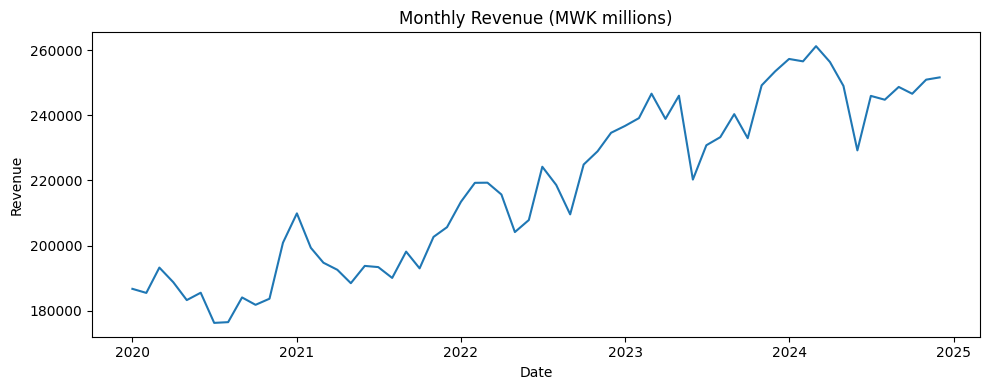

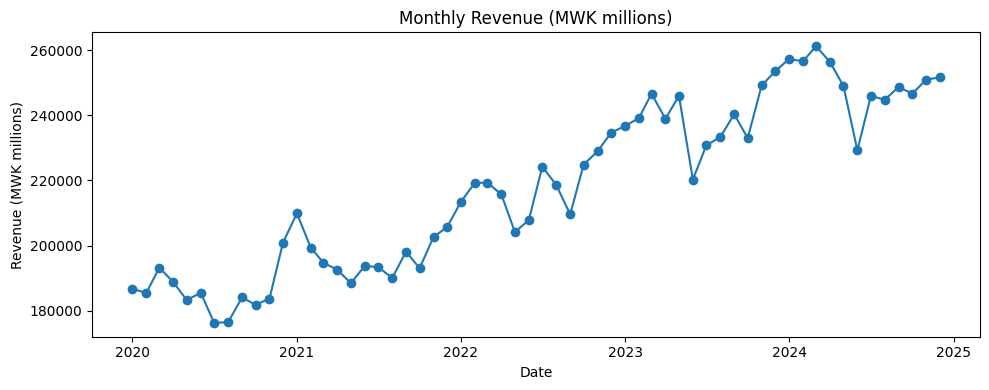

In [ ]:
# Basic checks
print(df.info())
display(df.describe().round(2))

# Plot revenue
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['revenue_mwk_millions'])
plt.title('Monthly Revenue (MWK millions)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


# Combine year and month into a datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['revenue_mwk_millions'], marker='o')
plt.title('Monthly Revenue (MWK millions)')
plt.xlabel('Date')
plt.ylabel('Revenue (MWK millions)')
plt.tight_layout()
plt.show()


In [ ]:
df.describe() # Generates summary statistics of the DataFrame for all numeric columns

,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
count,60,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2022-06-16 15:12:00,2022.000000,6.500000,0.040191,0.080166,868.959876,108.807115,11.833333,28.666667,0.500000,217914.727402
min,2020-01-01 00:00:00,2020.000000,1.000000,0.025585,0.062470,745.949785,99.073293,4.000000,20.000000,0.000000,176261.911479
25%,2021-03-24 06:00:00,2021.000000,3.750000,0.033544,0.070509,810.101256,104.005803,8.750000,25.000000,0.000000,193358.237746
50%,2022-06-16 00:00:00,2022.000000,6.500000,0.040060,0.080695,866.218141,109.979533,12.000000,28.000000,0.500000,218942.231000
75%,2023-09-08 12:00:00,2023.000000,9.250000,0.047519,0.089619,931.078176,112.957487,15.000000,31.000000,1.000000,241473.531700
max,2024-12-01 00:00:00,2024.000000,12.000000,0.052576,0.100112,996.309723,118.344093,21.000000,42.000000,1.000000,261241.772806
std,NaN,1.426148,3.481184,0.008077,0.011197,70.356238,5.286054,3.888997,4.942608,0.504219,25726.619213


# For Montly Revenue Data:

Interpretation of Monthly Revenue Data

25% (Q1) = 193,358M
→ 25% of the months had revenues below this level, while 75% had revenues above 193,358M.

50% (Median) = 218,942M
→ Half of the months recorded revenues below this level and half above it.

75% (Q3) = 241,474M
→ 75% of the months had revenues below this level, with the top 25% above it.

Interquartile Range (IQR) = Q3 – Q1 = ~48,116M
→ This represents the typical spread of monthly revenue around the middle range.

Overall Insights

Revenues are growing steadily, with the median (218,942M) close to the mean (217,915M), showing a fairly balanced distribution.

Variation (IQR ≈ 48,116M) suggests moderate month-to-month fluctuations.

Outliers are likely linked to policy changes (e.g., post-2022), large one-off taxpayer payments, or intensified compliance actions/audits, which temporarily boost revenues.

# Macroeconomic Drivers
GDP Growth

Q1 (25th percentile) = 3.35% → 25% of the observed months had GDP growth at or below 3.35%.

Median (50th percentile) = 4.01% → half of the observations had GDP growth at or below 4.01%, and half above.

Q3 (75th percentile) = 4.75% → 75% of the observations recorded GDP growth at or below 4.75%.

Interpretation:
Revenue forecasts are positively correlated with GDP growth. Higher GDP growth indicates stronger economic activity, which expands the tax base and boosts collections. Periods above 4.75% GDP growth (top quartile) may correspond with significant upward shifts in revenue performance.

Inflation (CPI)

Q1 (25th percentile) = 7.05% → 25% of the months had inflation below 7.05%.

Median (50th percentile) = 8.07% → half of the months recorded inflation at or below 8.07%.

Q3 (75th percentile) = 8.96% → 75% of the months had inflation at or below 8.96%.

Interpretation:
Higher inflation can inflate nominal tax revenues (VAT, excise) as they are price-linked. However, sustained inflation above 8.96% (top quartile) risks eroding real revenue growth, distorting compliance, and reducing collection efficiency.

Exchange Rate (MWK/USD)

Q1 (25th percentile) = 810 → 25% of the months had the exchange rate below MWK 810/USD.

Median (50th percentile) = 866 → half of the months recorded an exchange rate at or below MWK 866/USD.

Q3 (75th percentile) = 931 → 75% of the months had the rate at or below MWK 931/USD.

Max = 996 → peak depreciation observed.

Interpretation:
Depreciation of the kwacha tends to raise the local currency value of imports, boosting import VAT, customs duty, and excise revenues. However, sharp depreciation beyond MWK 931/USD (75th percentile) may reflect macroeconomic instability, which can undermine taxpayer compliance and reduce real revenue sustainability.





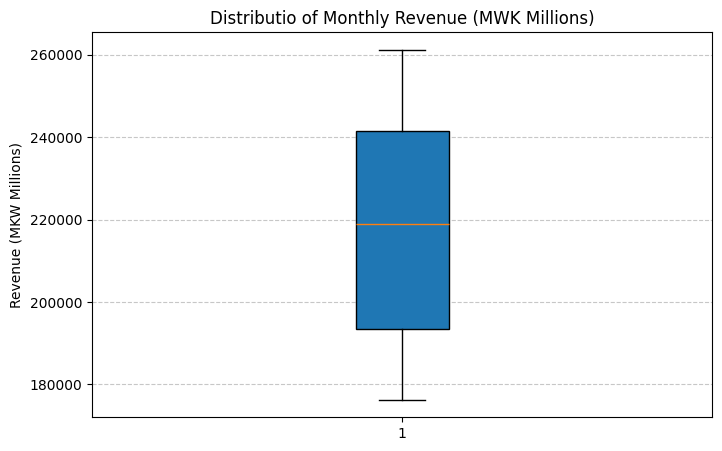

In [ ]:
# Boxplot for Revenue
plt.figure(figsize = (8,5))
plt.boxplot(df['revenue_mwk_millions'], vert = True, patch_artist = True)
plt.title('Distributio of Monthly Revenue (MWK Millions)')
plt.ylabel('Revenue (MKW Millions)')
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()


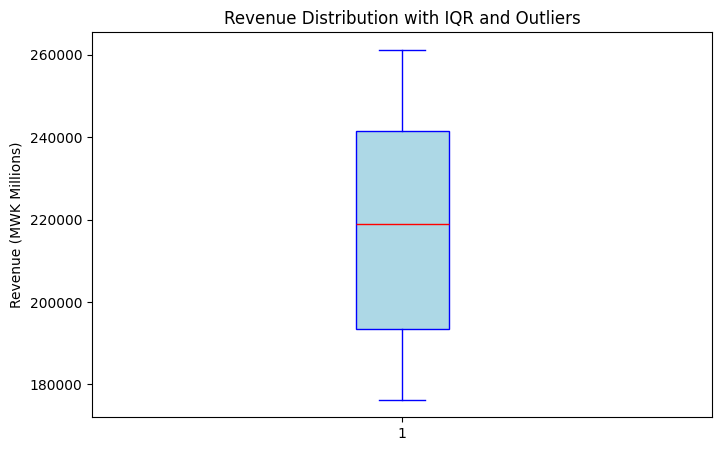

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.boxplot(df['revenue_mwk_millions'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='o', color='orange', markersize=8))

plt.title("Revenue Distribution with IQR and Outliers")
plt.ylabel("Revenue (MWK Millions)")
plt.show()


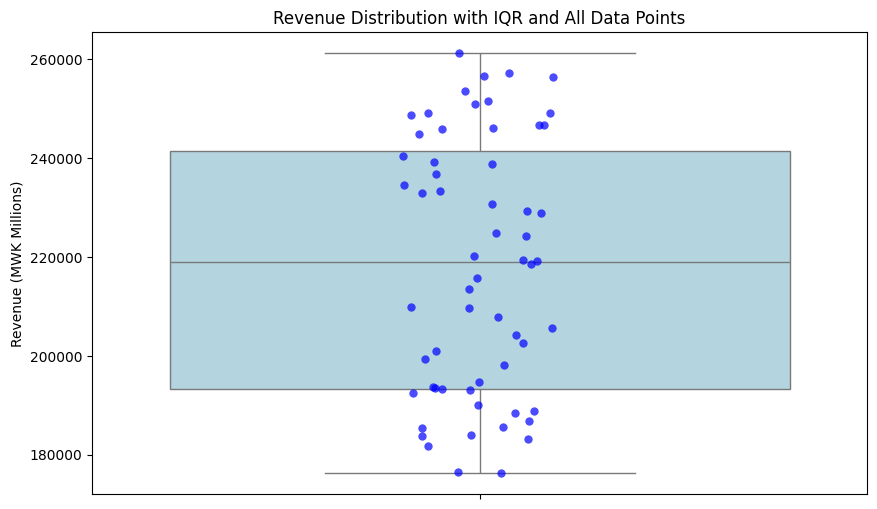

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# Create boxplot
sns.boxplot(y=df['revenue_mwk_millions'], color='lightblue')

# Overlay all individual data points
sns.stripplot(y=df['revenue_mwk_millions'], color='blue', size=6, jitter=True, alpha=0.7)

plt.title("Revenue Distribution with IQR and All Data Points")
plt.ylabel("Revenue (MWK Millions)")
plt.show()


# How to interpret your revenue boxplot:

If the median line is closer to the bottom of the box, the data is right-skewed
(some months have very high revenue).

If the median is near the top, the data is left-skewed (some months have very low revenue).

The distance between whiskers shows overall spread; wider whiskers → more variation in monthly revenue.

Outliers highlight months where revenue was unusually high or low — these could correspond to special events,
policy changes, or compliance drives.

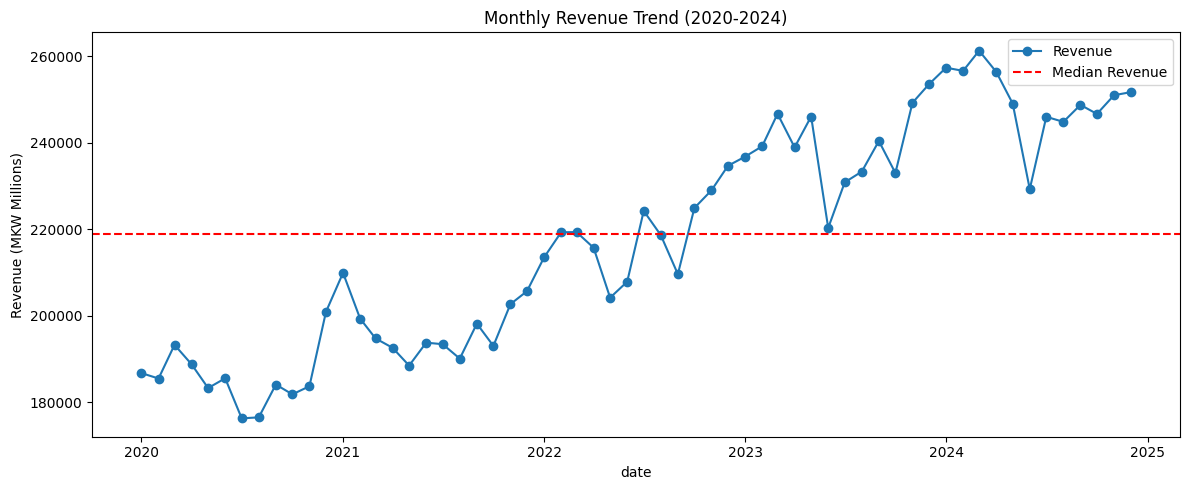

In [ ]:
#Revenue Trendline
plt.figure(figsize = (12,5))
plt.plot(df['date'], df['revenue_mwk_millions'], marker = 'o', label = 'Revenue')
plt.axhline(df['revenue_mwk_millions'].median(), color = 'red', linestyle = "--", label = "Median Revenue")
plt.title('Monthly Revenue Trend (2020-2024)')
plt.xlabel('date')
plt.ylabel('Revenue (MKW Millions)')
plt.legend()
plt.tight_layout()
plt.show()

# 2024 Revenue Trend Analysis

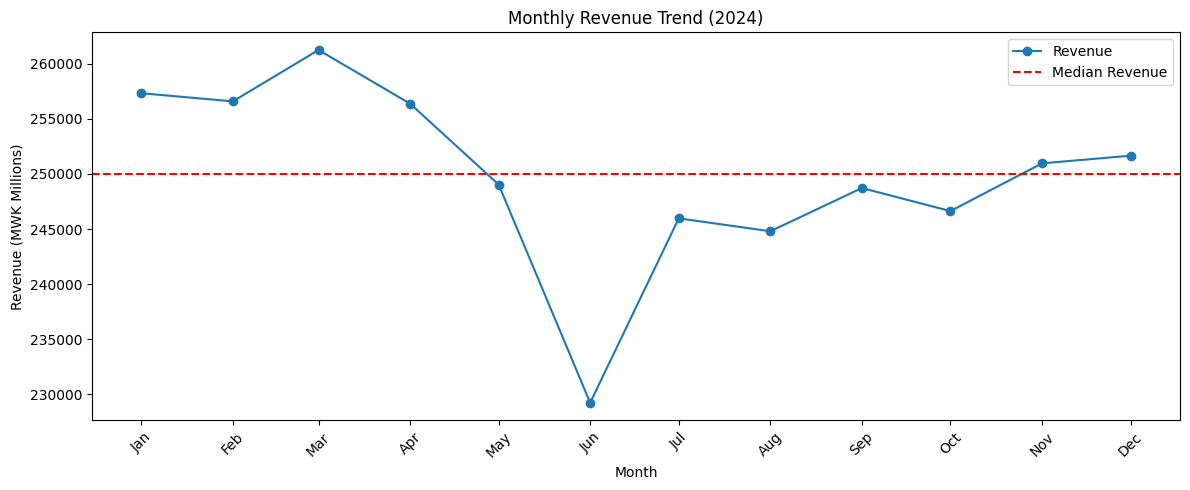

In [ ]:
import matplotlib.dates as mdates

# Filter data for 2024
df_2024 = df[df['date'].dt.year == 2024]

plt.figure(figsize=(12,5))
plt.plot(df_2024['date'], df_2024['revenue_mwk_millions'], marker='o', label='Revenue')

# Add median line (only for 2024 data)
plt.axhline(df_2024['revenue_mwk_millions'].median(), color='red', linestyle="--", label="Median Revenue")

plt.title('Monthly Revenue Trend (2024)')

# Format x-axis to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))   # e.g., Jan, Feb, Mar
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # every month

plt.xticks(rotation=45)

plt.xlabel('Month')
plt.ylabel('Revenue (MWK Millions)')
plt.legend()
plt.tight_layout()
plt.show()


## 4) Data Cleaning

Fill missing macro values (ffill/bfill) and ensure chronological order.

In [ ]:
# Fill missing macro data using forward/backward fill
df_sorted = df.sort_values('date').copy()
df_sorted[['gdp_growth','cpi_inflation','fx_mwk_usd']] = df_sorted[['gdp_growth','cpi_inflation','fx_mwk_usd']].ffill().bfill()

# Confirm no missing values left for modelling features
df_sorted.isnull().sum()

,0
date,0
year,0
month,0
gdp_growth,0
cpi_inflation,0
fx_mwk_usd,0
fuel_price_index,0
audits_launched,0
compliance_actions,0
policy_change,0


In [ ]:
df_sorted.head()

,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,revenue_mwk_millions
0,2020-01-01,2020,1,0.043022,0.085871,765.538941,101.008446,8,39,0,186717.004505
1,2020-02-01,2020,2,0.047925,0.091315,770.041447,102.961833,12,24,0,185468.555784
2,2020-03-01,2020,3,0.052576,0.094051,762.044909,103.813189,11,28,0,193243.884071
3,2020-04-01,2020,4,0.049048,0.091608,745.949785,102.747280,13,26,0,188749.786887
4,2020-05-01,2020,5,0.046840,0.083191,747.253058,100.974620,13,28,0,183261.906810


## 5) Feature Engineering & Transformations

Create time-series features: cyclic month indicators, lag features, rolling statistics, and log-transform the target to stabilize variance.

In [ ]:
# Seasonality as cyclic features
# Months are cylcic: January comes after December in a loop
# Using sine and cosine transformations helps ML models understand this cyclic nature
# month_sin and month_cos are numeric representations of the month that capture seasonality
df_sorted['month_sin'] = np.sin(2 * np.pi * df_sorted['month'] / 12)
df_sorted['month_cos'] = np.cos(2 * np.pi * df_sorted['month'] / 12)

# Lags and rolling statistics (use past data only)

# Lag means using past values of revenue as features.
# e.g. rev_lag_1 means revenue 1 month ago, rev_lag_12,  revenue 12 months ago
# this helps the model learn patterns from past months
for lag in [1,3,6,12]:
    df_sorted[f'rev_lag_{lag}'] = df_sorted['revenue_mwk_millions'].shift(lag)

# Rolling Statistics
# Computes moving averages and standard deviations over a period
# .shift(1) ensures only past data is used (prevents peeking into the future)
#rev_roll_3 means average revenue of the past 3 months
# This captures recent trends and volatility in revenue
for w in [3,6]:
    df_sorted[f'rev_roll_mean_{w}'] = df_sorted['revenue_mwk_millions'].shift(1).rolling(w).mean()
    df_sorted[f'rev_roll_std_{w}'] = df_sorted['revenue_mwk_millions'].shift(1).rolling(w).std()

# Log-transform target
# Transforms revenue to log scale using log1p (log(1+x)).
# Makes data less skewed if there are very large or small values
#Helps the model to learn patterns more easily
df_sorted['log_revenue'] = np.log1p(df_sorted['revenue_mwk_millions'])

# Drop initial rows with NaNs from lags

#Lag and rolling calculations create NaNs at the start,
#we remove those rows to ensure clean dataset ready for modelling
df_model = df_sorted.dropna().reset_index(drop=True)
print('Model dataset shape:', df_model.shape)
df_model.head()

# Prints the shape of the dataset after all features are created.
#You now have a dataset with original revenue, lag features,
#rolling stats, cyclic month features, and log-transformed target, ready for machine learning.

#Created Feature-rich dataset where the model can use
#past revenue or lags
#recent trends (rolling mean and std)
#seasonal patterns (month_sin & month_cos)
#Log-transformed target for stability
  # Perfect for time series forecasting

Model dataset shape: (48, 22)


,date,year,month,gdp_growth,cpi_inflation,fx_mwk_usd,fuel_price_index,audits_launched,compliance_actions,policy_change,...,month_cos,rev_lag_1,rev_lag_3,rev_lag_6,rev_lag_12,rev_roll_mean_3,rev_roll_std_3,rev_roll_mean_6,rev_roll_std_6,log_revenue
0,2021-01-01,2021,1,0.047384,0.090359,811.792005,105.949449,18,42,0,...,8.660254e-01,200873.864687,181808.741553,176261.911479,186717.004505,188788.903974,10507.804443,183865.029254,9009.391040,12.254351
1,2021-02-01,2021,2,0.047318,0.097549,827.919955,105.590658,21,32,0,...,5.000000e-01,209891.631063,183684.105683,176487.165804,185468.555784,198149.867144,13314.417696,189469.982518,12937.768199,12.202682
2,2021-03-01,2021,3,0.052001,0.100112,805.029011,107.324726,7,28,0,...,6.123234e-17,199321.936536,200873.864687,184074.386319,193243.884071,203362.477429,5707.407961,193275.777640,11649.311043,12.179437
3,2021-04-01,2021,4,0.048933,0.092244,793.048690,107.248293,11,26,0,...,-5.000000e-01,194742.208098,209891.631063,181808.741553,188749.786887,201318.591899,7769.570678,195053.747937,10742.904493,12.168186
4,2021-05-01,2021,5,0.048064,0.086001,800.347633,106.141133,16,27,0,...,-8.660254e-01,192563.423196,199321.936536,183684.105683,183261.906810,195542.522610,3449.601880,196846.194877,8815.263033,12.146615


## 6) Correlations and Visual Inspection

Compute correlation matrix to detect collinearity and relationships.

df_model.corr() calculates the Pearson Correlation Coefficient between all numeric columns in your dataset

The correlation value ranges from -1 to +1:

1 - Perfect positive correlation (as one increases, the other increases)
                                  
0 - no correlation
                                  
-1 - perfect negative correlation (as one increases, the other decreases)
                                  
numeric_only = True ensures only numeric columns are considered


corr.loc[:, ['revenue_mwk_millions']] selects correction of all features with the Target Variable
This helps identify which features are most strongly related to the Target/Revenue

.sort_values('revenue_mwk_millions', ascending=False)
Sorts features in descending order of correlation with revenue.

Features with the highest positive correlation appear first.

In [ ]:
corr = df_model.corr(numeric_only=True)
corr.loc[:, ['revenue_mwk_millions']].sort_values('revenue_mwk_millions', ascending=False).head(10)

,revenue_mwk_millions
revenue_mwk_millions,1.000000
log_revenue,0.999169
rev_lag_1,0.923025
year,0.922386
fuel_price_index,0.909375
rev_lag_12,0.909039
rev_roll_mean_3,0.907505
fx_mwk_usd,0.885216
rev_roll_mean_6,0.884755
policy_change,0.842808


You are finding which features (lags, rolling stats, month sin/cos, etc.)
are most strongly related to the current revenue.

Features at the top are strong predictors for your model.

This is a quick way to understand which past months, trends, or seasonality features matter most.

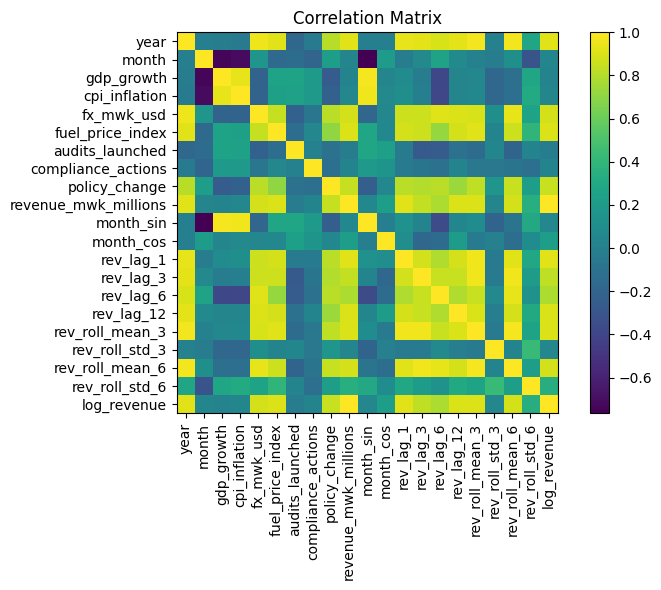

In [ ]:
# Heatmap (matplotlib only)
# Shows a color scale from low (e.g., -1, negative correlation) to high (e.g., 1, positive correlation).

#Color intensity shows the strength of correlation:

#Darker or more intense color → stronger correlation

#Lighter color → weaker correlation

#Diagonal line from top-left to bottom-right is always perfect correlation (1) because a feature is perfectly correlated with itself.

#Off-diagonal cells show correlations between different features:

#Positive correlation → features increase together

#Negative correlation → one feature increases while the other decreases
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

## 7) Statistical Significance (OLS) — p-values
Ordinary Least Squares Regression

Run an OLS regression with candidate predictors and use p-values (p<0.05) to select significant features. Keep core time-series predictors (lag1, seasonality) regardless of p-value.

In [ ]:
# Prepare OLS features
# Include all potential factors that might affect revenue.
# Economic Factors: GDP Growth, inflation, exchange rate
# Operational factors: audits launched, compliance actions, policy changes
# Seasonality: month represented as sine/cosine
# Past revenue info: lagged revenue,rolling averages, rolling standard deviations
ols_features = [
    'gdp_growth','cpi_inflation','fx_mwk_usd','fuel_price_index',
    'audits_launched','compliance_actions','policy_change',
    'month_sin','month_cos',
    'rev_lag_1','rev_lag_3','rev_lag_6','rev_lag_12',
    'rev_roll_mean_3','rev_roll_mean_6','rev_roll_std_3','rev_roll_std_6'
]
X_ols = sm.add_constant(df_model[ols_features]) # X_ols independent variables with a constant added for the intercept
y_ols = df_model['log_revenue'] # y_ols target variable, which is log-transformed revenue
ols_res = sm.OLS(y_ols, X_ols).fit() # sm.OLS(y_ols, X_ols).fit()  fits a linear regression model
print(ols_res.summary()) # prints statistics like coefficients, how much each feature affects revenue
# and p-values - whether the effect is statistically siginificant
# R-squared - how well the model explains revenue

# Select significant variables
# Inspects P-values of each feature (ignoring the intercept)
# A p-value <0.05 means the feature has a strong, reliable effect on revenue
# only these significant features are kept for modelling
pvalues = ols_res.pvalues.drop('const', errors='ignore')
significant_feats = pvalues[pvalues < 0.05].index.tolist()
# ensure core features present
for f in ['rev_lag_1','month_sin','month_cos']:
    if f not in significant_feats:
        significant_feats.append(f)
print('\nSelected features for modeling:', significant_feats)

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     37.66
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.23e-15
Time:                        04:55:57   Log-Likelihood:                 117.98
No. Observations:                  48   AIC:                            -200.0
Df Residuals:                      30   BIC:                            -166.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.6530      0

## 8) Train/Test Split (80:20)




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from prophet import Prophet
from math import sqrt

In [ ]:
# Train/Test Split (80/20)
# -----------------------------
X = df_model[significant_feats]
y = df_model['log_revenue']   # log-transformed revenue

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [ ]:
# Define models
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=300, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []

In [ ]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    results.append({"model": name, "R2": r2, "RMSE": rmse})


In [ ]:
# Prophet (time-series model)
# -----------------------------
prophet_df = df_model[['date', 'log_revenue']].rename(columns={'date':'ds','log_revenue':'y'})
train_size = int(len(prophet_df) * 0.8)

train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_df)

future = test_df[['ds']]
forecast = prophet_model.predict(future)

y_true = test_df['y'].values
y_pred = forecast['yhat'].values

prophet_r2 = r2_score(y_true, y_pred)
prophet_rmse = sqrt(mean_squared_error(y_true, y_pred))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91kftdj5/3txt0olk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91kftdj5/s1j1c4nk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11480', 'data', 'file=/tmp/tmp91kftdj5/3txt0olk.json', 'init=/tmp/tmp91kftdj5/s1j1c4nk.json', 'output', 'file=/tmp/tmp91kftdj5/prophet_modelbq3svd1q/prophet_model-20250906052301.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
results.append({"model": "Prophet", "R2": prophet_r2, "RMSE": prophet_rmse})

# -----------------------------
# Results DataFrame
# -----------------------------
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print(results_df)

              model        R2      RMSE
6           XGBoost  0.717064  0.017338
1             Lasso  0.273963  0.027774
0  LinearRegression  0.263340  0.027976
3          AdaBoost  0.262737  0.027987
2      RandomForest  0.016173  0.032330
4               KNN -0.714657  0.042682
7           Prophet -3.275887  0.067401
5               SVM -4.105978  0.073653


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from prophet import Prophet
from math import sqrt

# -----------------------------
# Train/Test Split (80/20)
# -----------------------------
X = df_model[significant_feats]
y = df_model['log_revenue']   # log-transformed revenue

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -----------------------------
# Define models
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=300, random_state=42),
    #"KNN": KNeighborsRegressor(n_neighbors=5),
    #"SVM": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []

# -----------------------------
# Train and evaluate each model
# -----------------------------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    results.append({"model": name, "R2": r2, "RMSE": rmse})

# -----------------------------
# Prophet (time-series model)
# -----------------------------
prophet_df = df_model[['date', 'log_revenue']].rename(columns={'date':'ds','log_revenue':'y'})
train_size = int(len(prophet_df) * 0.8)

train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_df)

future = test_df[['ds']]
forecast = prophet_model.predict(future)

y_true = test_df['y'].values
y_pred = forecast['yhat'].values

prophet_r2 = r2_score(y_true, y_pred)
prophet_rmse = sqrt(mean_squared_error(y_true, y_pred))

results.append({"model": "Prophet", "R2": prophet_r2, "RMSE": prophet_rmse})

# -----------------------------
# Results DataFrame
# -----------------------------
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print(results_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91kftdj5/gbpour_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp91kftdj5/dmxi65_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81223', 'data', 'file=/tmp/tmp91kftdj5/gbpour_g.json', 'init=/tmp/tmp91kftdj5/dmxi65_d.json', 'output', 'file=/tmp/tmp91kftdj5/prophet_modele6jn24vc/prophet_model-20250906054526.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


              model        R2      RMSE
4           XGBoost  0.717064  0.017338
1             Lasso  0.273963  0.027774
0  LinearRegression  0.263340  0.027976
3          AdaBoost  0.262737  0.027987
2      RandomForest  0.016173  0.032330
5           Prophet -3.275887  0.067401


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features selected via OLS
X = df_model[significant_feats]
y = df_model['log_revenue']  # log-transformed revenue

# Time-based train-test split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scale features for models that require it (ANN, Linear, Lasso, KNN, SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid,
    n_iter=20, cv=tscv, scoring='r2', n_jobs=-1, random_state=42
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
y_pred_xgb = best_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid,
    n_iter=20, cv=tscv, scoring='r2', n_jobs=-1, random_state=42
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
y_pred_xgb = best_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.001, max_iter=10000, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=300, random_state=42),
    #'KNN': KNeighborsRegressor(n_neighbors=5),
    #'SVM': SVR(kernel='rbf')
}

results = []

for name, model in models.items():
    if name in ['KNN', 'SVM', 'Lasso', 'LinearRegression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'model': name, 'R2': r2, 'RMSE': rmse})

In [ ]:
results.append({'model': 'XGBoost_Tuned', 'R2': r2_xgb, 'RMSE': rmse_xgb})


In [ ]:
# Simple weighted average ensemble (XGBoost + ANN)
y_pred_ensemble = (0.6 * y_pred_xgb + 0.4 * y_pred_ann)
r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

results.append({'model': 'Ensemble_XGB_ANN', 'R2': r2_ensemble, 'RMSE': rmse_ensemble})


In [ ]:
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(results_df)


              model         R2      RMSE
4     XGBoost_Tuned   0.838380  0.013104
1             Lasso   0.335911  0.026562
0  LinearRegression   0.263340  0.027976
3          AdaBoost   0.262737  0.027987
2      RandomForest   0.016173  0.032330
5  Ensemble_XGB_ANN -86.084547  0.304175


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# ---------------------------
# 1️⃣ Prepare test set
# ---------------------------
# X_test and y_test already defined (from previous 80/20 split)
# XGBoost works best on unscaled features
# Ensure X_test matches the features used in training
X_test_xgb = X_test

# ---------------------------
# 2️⃣ Predict with XGBoost_Tuned
# ---------------------------
y_pred_xgb = best_xgb.predict(X_test_xgb)

# Evaluate performance on test set
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost_Tuned -> Test R²: {r2_xgb:.3f}, RMSE: {rmse_xgb:.3f}")

# ---------------------------
# 3️⃣ Prepare forecast DataFrame
# ---------------------------
forecast_df = pd.DataFrame({
    'date': df_model['date'].iloc[train_size:],  # test period dates
    'actual_revenue': y_test,
    'pred_xgb': y_pred_xgb
})

# If log transformation was applied, invert it
forecast_df[['actual_revenue', 'pred_xgb']] = np.exp(forecast_df[['actual_revenue', 'pred_xgb']])

# ---------------------------
# 4️⃣ Save to Excel
# ---------------------------
forecast_df.to_excel('tax_revenue_forecasts_xgb.xlsx', index=False)
print("Forecasts saved to 'tax_revenue_forecasts_xgb.xlsx'")

# Display first few rows
forecast_df.head(10)


XGBoost_Tuned -> Test R²: 0.838, RMSE: 0.013
Forecasts saved to 'tax_revenue_forecasts_xgb.xlsx'


,date,actual_revenue,pred_xgb
38,2024-03-01,261242.772806,256298.437500
39,2024-04-01,256373.846404,253474.343750
40,2024-05-01,249032.458477,249241.843750
41,2024-06-01,229241.787519,236794.406250
42,2024-07-01,245971.482195,246823.453125
43,2024-08-01,244796.580126,243639.578125
44,2024-09-01,248721.640899,249744.843750
45,2024-10-01,246630.072849,247539.125000
46,2024-11-01,250957.528408,250361.734375
47,2024-12-01,251652.924709,254191.875000


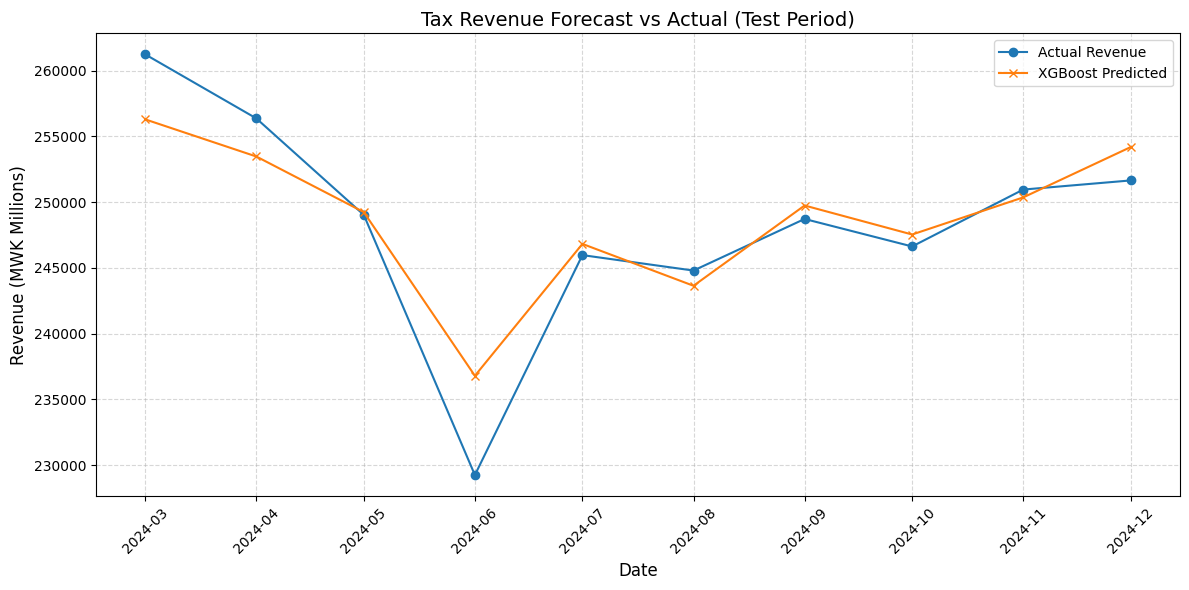

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted revenue
plt.figure(figsize=(12,6))
plt.plot(forecast_df['date'], forecast_df['actual_revenue'], label='Actual Revenue', marker='o')
plt.plot(forecast_df['date'], forecast_df['pred_xgb'], label='XGBoost Predicted', marker='x')

plt.title('Tax Revenue Forecast vs Actual (Test Period)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (MWK Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
mape = np.mean(np.abs((forecast_df['actual_revenue'] - forecast_df['pred_xgb']) / forecast_df['actual_revenue'])) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 0.92%


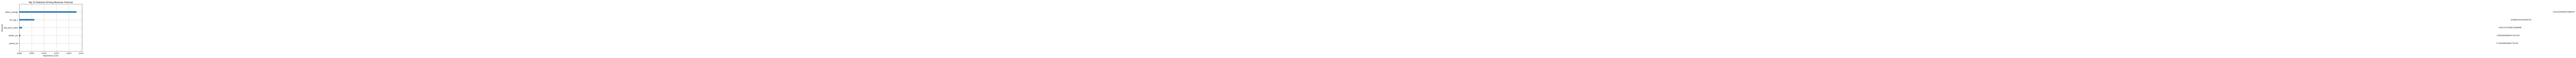

In [ ]:
# Feature Importance Analysis

# Identify key drivers of revenue using XGBoost’s built-in feature importance:

import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb, max_num_features=5, importance_type='gain')
plt.title("Top 10 Features Driving Revenue Forecast")
plt.show()

           Model        R2         RMSE  MAPE (%)
0  XGBoost_Tuned  0.777881  3756.069026  1.150219


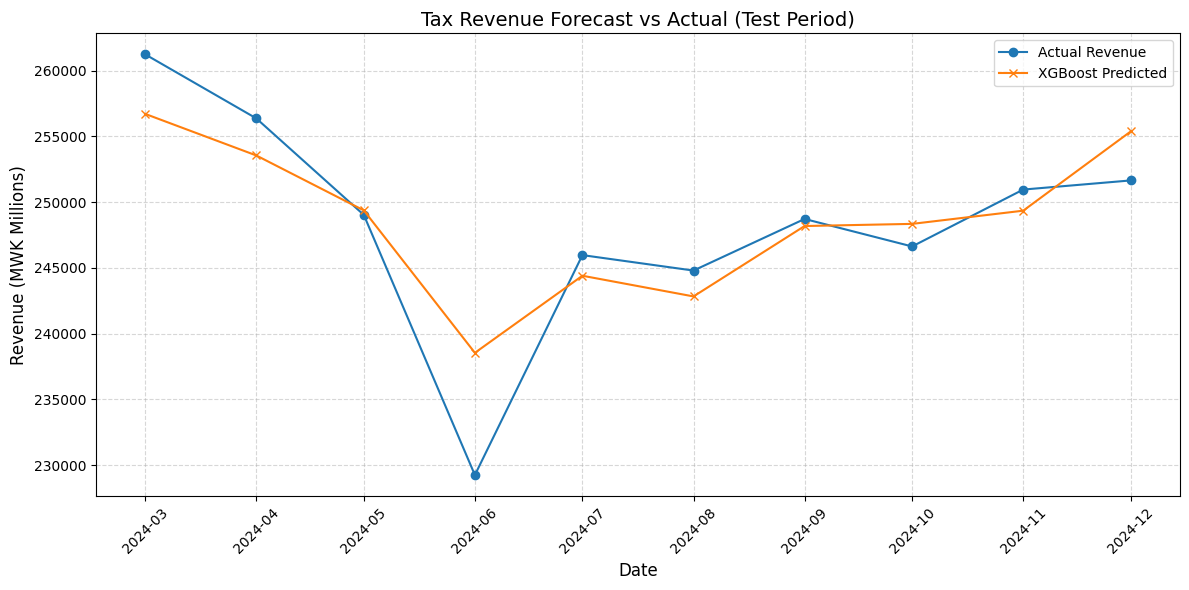

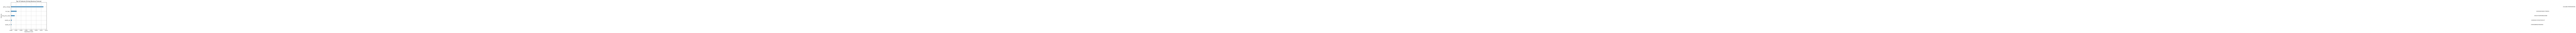

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# ---------------------------
# 1️⃣ Prepare Data (Train/Test Split)
# ---------------------------
X = df_model[significant_feats]  # features selected from OLS
y = df_model['log_revenue']      # log-transformed revenue

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# XGBoost works better on unscaled features
X_train_xgb, X_test_xgb = X_train, X_test

# ---------------------------
# 2️⃣ Train XGBoost_Tuned
# ---------------------------
best_xgb = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
best_xgb.fit(X_train_xgb, y_train)

# ---------------------------
# 3️⃣ Predict on Test Set
# ---------------------------
y_pred_xgb = best_xgb.predict(X_test_xgb)

# Invert log transformation
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred_xgb)

# ---------------------------
# 4️⃣ Compute Performance Metrics
# ---------------------------
r2 = r2_score(y_test_exp, y_pred_exp)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
mape = np.mean(np.abs((y_test_exp - y_pred_exp)/y_test_exp)) * 100

metrics_df = pd.DataFrame({
    'Model': ['XGBoost_Tuned'],
    'R2': [r2],
    'RMSE': [rmse],
    'MAPE (%)': [mape]
})
print(metrics_df)

# ---------------------------
# 5️⃣ Create Forecast Excel
# ---------------------------
forecast_df = pd.DataFrame({
    'date': df_model['date'].iloc[train_size:],
    'actual_revenue': y_test_exp,
    'pred_xgb': y_pred_exp
})
forecast_df.to_excel('tax_revenue_forecast_dashboard.xlsx', index=False)

# ---------------------------
# 6️⃣ Plot Actual vs Predicted
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(forecast_df['date'], forecast_df['actual_revenue'], label='Actual Revenue', marker='o')
plt.plot(forecast_df['date'], forecast_df['pred_xgb'], label='XGBoost Predicted', marker='x')
plt.title('Tax Revenue Forecast vs Actual (Test Period)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (MWK Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 7️⃣ Feature Importance Plot
# ---------------------------
xgb.plot_importance(best_xgb, max_num_features=10, importance_type='gain')
plt.title("Top 10 Features Driving Revenue Forecast")
plt.show()


In [ ]:
import joblib
from datetime import datetime

# Save XGBoost model
model_filename = f"xgboost_tuned_model_{datetime.now().strftime('%Y%m%d')}.joblib"
joblib.dump(best_xgb, model_filename)
print(f"Model saved as {model_filename}")


Model saved as xgboost_tuned_model_20250906.joblib


In [ ]:


# Forecast horizon
future_months = pd.date_range(start='2025-01-01', end='2026-12-01', freq='MS')
n_future = len(future_months)

# Initialize DataFrame
future_df = pd.DataFrame({'date': future_months})
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month

# ---------------------------
# 2a. Generate features
# ---------------------------
# Seasonality
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month']/12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month']/12)

# Macro assumptions (example: use last known values)
last_row = df_model.iloc[-1]

future_df['gdp_growth'] = 0.041  # projected GDP growth
future_df['cpi_inflation'] = 0.085  # projected CPI
future_df['fx_mwk_usd'] = last_row['fx_mwk_usd'] + 5*np.arange(1, n_future+1)  # linear trend
future_df['fuel_price_index'] = last_row['fuel_price_index'] + 0.5*np.arange(1, n_future+1)

# Operational assumptions
future_df['audits_launched'] = int(df_model['audits_launched'].mean())
future_df['compliance_actions'] = int(df_model['compliance_actions'].mean())
future_df['policy_change'] = 0  # assume no policy change

# Lagged revenue features (recursive forecast)
rev_lag = list(df_model['log_revenue'].iloc[-12:])  # last 12 months

future_rev_preds = []
for i in range(n_future):
    # Lag features
    future_df.loc[i,'rev_lag_1'] = rev_lag[-1]
    future_df.loc[i,'rev_lag_3'] = np.mean(rev_lag[-3:])
    future_df.loc[i,'rev_lag_6'] = np.mean(rev_lag[-6:])
    future_df.loc[i,'rev_lag_12'] = np.mean(rev_lag[-12:])
    # Rolling stats
    future_df.loc[i,'rev_roll_mean_3'] = np.mean(rev_lag[-3:])
    future_df.loc[i,'rev_roll_mean_6'] = np.mean(rev_lag[-6:])
    future_df.loc[i,'rev_roll_std_3'] = np.std(rev_lag[-3:])
    future_df.loc[i,'rev_roll_std_6'] = np.std(rev_lag[-6:])

    # Predict log revenue
    X_future = future_df.loc[i, significant_feats].values.reshape(1,-1)
    log_rev_pred = best_xgb.predict(X_future)[0]

    # Store predicted revenue
    future_rev_preds.append(log_rev_pred)

    # Update lag list for next iteration
    rev_lag.append(log_rev_pred)

# Convert log revenue to actual revenue
future_df['predicted_revenue'] = np.exp(future_rev_preds)

# Save future forecasts
future_df[['date','predicted_revenue']].to_excel('future_revenue_forecasts_2025_2026.xlsx', index=False)
future_df[['date','predicted_revenue']].head(12)


,date,predicted_revenue
0,2025-01-01,221661.468750
1,2025-02-01,218413.359375
2,2025-03-01,218336.500000
3,2025-04-01,216311.625000
4,2025-05-01,216611.156250
5,2025-06-01,216092.656250
6,2025-07-01,217498.140625
7,2025-08-01,217816.750000
8,2025-09-01,221648.984375
9,2025-10-01,220221.078125


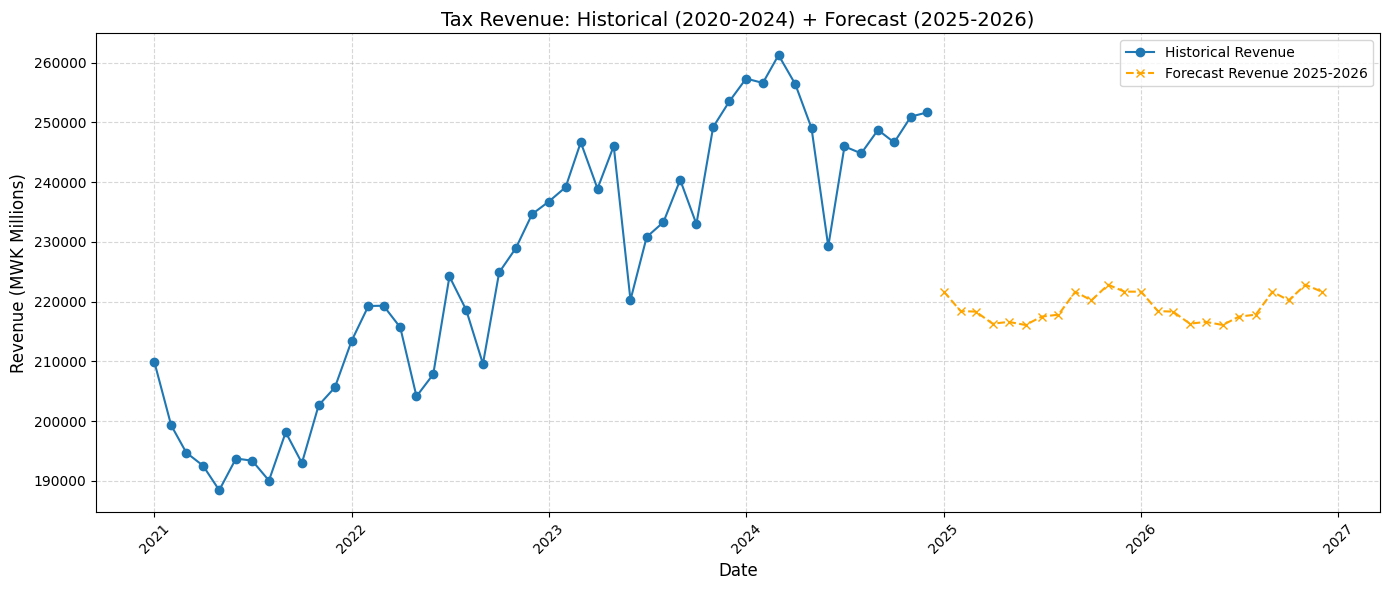

In [ ]:
import matplotlib.pyplot as plt

# Historical revenue (actual)
historical_df = df_model[['date', 'revenue_mwk_millions']].copy()
historical_df.rename(columns={'revenue_mwk_millions':'revenue'}, inplace=True)

# Future forecast
forecast_df = future_df[['date','predicted_revenue']].copy()
forecast_df.rename(columns={'predicted_revenue':'revenue'}, inplace=True)

# Combine
combined_df = pd.concat([historical_df, forecast_df], ignore_index=True)

# Plot
plt.figure(figsize=(14,6))
plt.plot(historical_df['date'], historical_df['revenue'], label='Historical Revenue', marker='o')
plt.plot(forecast_df['date'], forecast_df['revenue'], label='Forecast Revenue 2025-2026', marker='x', linestyle='--', color='orange')
plt.title('Tax Revenue: Historical (2020-2024) + Forecast (2025-2026)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (MWK Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import joblib
from datetime import datetime

# Define a versioned filename
model_filename = f"xgboost_tuned_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"

# Save the trained model
joblib.dump(best_xgb, model_filename)

print(f"✅ Model saved successfully as {model_filename}")


✅ Model saved successfully as xgboost_tuned_model_20250906_060606.joblib


## 13) Save model & production notes

- Save the trained model (joblib) and maintain a versioned dataset snapshot for reproducibility.
- Schedule monthly re-training and monitor forecast drift (MAPE thresholds).
- Document data lineage, assumptions for macro inputs, and governance.

**Example commands** (uncomment to run in real environment):

```python
# import joblib
# joblib.dump(best_model, 'revenue_model_best.joblib')
```

## 14) Classroom exercises and extensions

1. Replace simulated data with your Actual Tax Administration monthly revenue and macro variables; re-run pipeline.
2. Add additional features: filing deadlines, one-off policy shocks, e-invoice rollout dummy.
3. Try more algorithms (XGBoost, Prophet, SARIMAX) and compare performance.
4. Build a Power BI dashboard that reads the forecast CSV and displays MTD/YTD comparisons.

---

